In [1]:
%cd ../..

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [2]:
import numpy as np
import pandas as pd
import os
import math
from pathlib import Path
from tqdm.autonotebook import tqdm
import warnings
from src.utils.general import LogTime
import plotly.express as px
%load_ext autoreload
%autoreload 2
np.random.seed(42)
tqdm.pandas()

C:\Users\MANUJO~1\AppData\Local\Temp/ipykernel_5692/3965637783.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.makedirs("imgs/chapter_6", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")

# Reading the preprocessed files

In [4]:
#Readin the missing value imputed and train test split data
train_df = pd.read_parquet(preprocessed/"block_0-7_train_missing_imputed.parquet")
val_df = pd.read_parquet(preprocessed/"block_0-7_val_missing_imputed.parquet")
test_df = pd.read_parquet(preprocessed/"block_0-7_test_missing_imputed.parquet")

## Combining the train, validation and test datasets for Feature Engineering

Some of the features that we are creating needs the train and test dataset to be combined into a single dataset with continuous time. In case of real-life operations, where we will not have the test set, it is recommended to create the test period dataset with zero or nulled out actual observations and continue.

In [5]:
train_df['type'] = "train"
val_df['type'] = "val"
test_df['type'] = "test"
full_df = pd.concat([train_df, val_df, test_df]).sort_values(["LCLid", "timestamp"])
del train_df, test_df, val_df

## Lag Features

In [6]:
from src.feature_engineering.autoregressive_features import add_lags

In [7]:
with LogTime():
    full_df, added_features = add_lags(full_df, lags=(np.arange(5)+1).tolist()+(np.arange(5)+1+48).tolist(), column="energy_consumption", ts_id="LCLid", use_32_bit=True)
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 2 seconds
Features Created: energy_consumption_lag_1,energy_consumption_lag_2,energy_consumption_lag_3,energy_consumption_lag_4,energy_consumption_lag_5,energy_consumption_lag_49,energy_consumption_lag_50,energy_consumption_lag_51,energy_consumption_lag_52,energy_consumption_lag_53


## Rolling

In [8]:
from src.feature_engineering.autoregressive_features import add_rolling_features

In [9]:
with LogTime():
    full_df, added_features = add_rolling_features(full_df, rolls=[3, 6, 12, 48], column="energy_consumption", agg_funcs=['mean','std'], ts_id="LCLid", use_32_bit=True)
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 17 seconds
Features Created: energy_consumption_rolling_3_mean,energy_consumption_rolling_3_std,energy_consumption_rolling_6_mean,energy_consumption_rolling_6_std,energy_consumption_rolling_12_mean,energy_consumption_rolling_12_std,energy_consumption_rolling_48_mean,energy_consumption_rolling_48_std


## Seasonal Rolling

In [10]:
from src.feature_engineering.autoregressive_features import add_seasonal_rolling_features

In [11]:
with LogTime():
    full_df, added_features = add_seasonal_rolling_features(full_df, 
                                                            rolls=[3], 
                                                            seasonal_periods=[48, 48*7], 
                                                            column="energy_consumption", 
                                                            agg_funcs=['mean','std'], 
                                                            ts_id="LCLid", 
                                                            use_32_bit=True)
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 9 seconds
Features Created: energy_consumption_48_seasonal_rolling_3_mean,energy_consumption_48_seasonal_rolling_3_std,energy_consumption_336_seasonal_rolling_3_mean,energy_consumption_336_seasonal_rolling_3_std


## EWMA

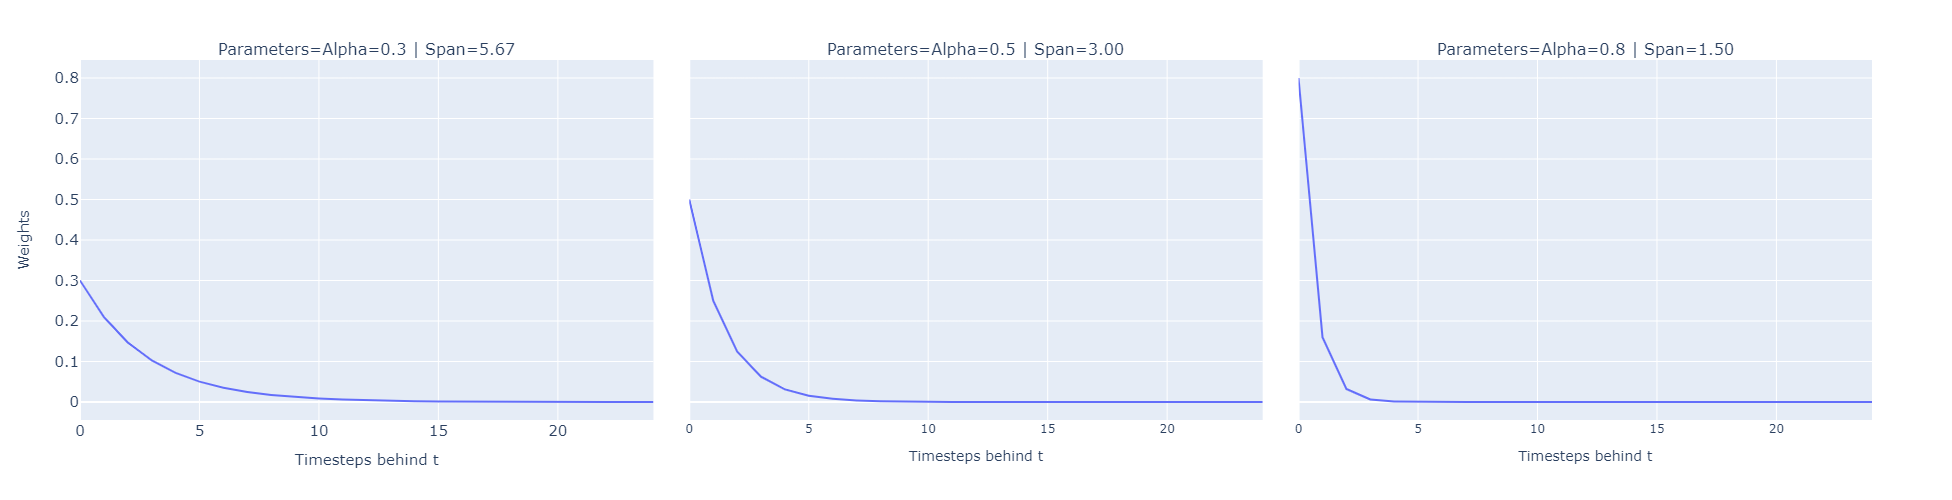

In [8]:
t = np.arange(25).tolist()
plot_df = pd.DataFrame({"Timesteps behind t": t})
for alpha in [0.3, 0.5, 0.8]:
    weights = [alpha * math.pow((1 - alpha), i) for i in t]
    span = (2 - alpha) / alpha
    halflife = math.log(1 - alpha) / math.log(0.5)
    plot_df[f"Alpha={alpha} | Span={span:.2f}"] = weights

fig = px.line(
    pd.melt(plot_df, id_vars="Timesteps behind t", var_name="Parameters"),
    x="Timesteps behind t",
    y="value",
    facet_col="Parameters",
)
fig.update_layout(
    autosize=False,
    width=1200,
    height=500,
    yaxis=dict(
        title_text="Weights",
        titlefont=dict(size=15),
        tickfont=dict(size=15),
    ),
    xaxis=dict(
        titlefont=dict(size=15),
        tickfont=dict(size=15),
    ),
)
fig.update_annotations(font=dict(size=16))
fig.write_image(f"imgs/chapter_6/ewma_weights.png")
fig.show()

In [13]:
from src.feature_engineering.autoregressive_features import add_ewma

In [14]:
with LogTime():
    # full_df, added_features = add_ewma(full_df, alphas=[0.2, 0.5, 0.9], column="energy_consumption", ts_id="LCLid", use_32_bit=True)
    full_df, added_features = add_ewma(full_df, spans=[48*60, 48*7, 48], column="energy_consumption", ts_id="LCLid", use_32_bit=True)
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 1 second
Features Created: energy_consumption_ewma__span_2880,energy_consumption_ewma__span_336,energy_consumption_ewma__span_48


## Temporal Features

In [15]:
from src.feature_engineering.temporal_features import add_temporal_features

In [16]:
with LogTime():
    full_df, added_features = add_temporal_features(full_df, field_name="timestamp", frequency="30min", add_elapsed=True, drop=False, use_32_bit=True)
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 9 seconds
Features Created: timestamp_Month,timestamp_Quarter,timestamp_Is_quarter_end,timestamp_Is_quarter_start,timestamp_Is_year_end,timestamp_Is_year_start,timestamp_Is_month_start,timestamp_WeekDay,timestamp_Dayofweek,timestamp_Dayofyear,timestamp_Hour,timestamp_Minute,timestamp_Elapsed


## Fourier Terms

In [17]:
from src.feature_engineering.temporal_features import add_fourier_features, bulk_add_fourier_features

In [18]:
# train_df, added_features = add_fourier_features(train_df, "timestamp_Month", max_value=12, n_fourier_terms=1)

In [19]:
with LogTime():
    full_df, added_features = bulk_add_fourier_features(full_df, ["timestamp_Month", "timestamp_Hour", "timestamp_Minute"], max_values=[12, 24, 60], n_fourier_terms=5, use_32_bit=True)
print(f"Features Created: {','.join(added_features)}")

Time Elapsed: 1 minute and 35 seconds
Features Created: timestamp_Month_sin_1,timestamp_Month_sin_2,timestamp_Month_sin_3,timestamp_Month_sin_4,timestamp_Month_sin_5,timestamp_Month_cos_1,timestamp_Month_cos_2,timestamp_Month_cos_3,timestamp_Month_cos_4,timestamp_Month_cos_5,timestamp_Hour_sin_1,timestamp_Hour_sin_2,timestamp_Hour_sin_3,timestamp_Hour_sin_4,timestamp_Hour_sin_5,timestamp_Hour_cos_1,timestamp_Hour_cos_2,timestamp_Hour_cos_3,timestamp_Hour_cos_4,timestamp_Hour_cos_5,timestamp_Minute_sin_1,timestamp_Minute_sin_2,timestamp_Minute_sin_3,timestamp_Minute_sin_4,timestamp_Minute_sin_5,timestamp_Minute_cos_1,timestamp_Minute_cos_2,timestamp_Minute_cos_3,timestamp_Minute_cos_4,timestamp_Minute_cos_5


In [20]:
full_df.columns

Index(['timestamp', 'LCLid', 'energy_consumption', 'frequency',
       'series_length', 'stdorToU', 'Acorn', 'Acorn_grouped', 'file',
       'holidays', 'visibility', 'windBearing', 'temperature', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary', 'type', 'energy_consumption_lag_1',
       'energy_consumption_lag_2', 'energy_consumption_lag_3',
       'energy_consumption_lag_4', 'energy_consumption_lag_5',
       'energy_consumption_lag_49', 'energy_consumption_lag_50',
       'energy_consumption_lag_51', 'energy_consumption_lag_52',
       'energy_consumption_lag_53', 'energy_consumption_rolling_3_mean',
       'energy_consumption_rolling_3_std', 'energy_consumption_rolling_6_mean',
       'energy_consumption_rolling_6_std',
       'energy_consumption_rolling_12_mean',
       'energy_consumption_rolling_12_std',
       'energy_consumption_rolling_48_mean',
       'energy_consumption_rolling_48_std',
       'energy_con

In [21]:
plot_df = full_df[['timestamp_Month', 'timestamp_Month_sin_1']].drop_duplicates().sort_values("timestamp_Month")

plot_df.columns=["calendar", "fourier"]

plot_df = pd.concat([plot_df,plot_df,plot_df]).reset_index(drop=True)
# plot_df.reset_index(drop=True, inplace=True)

plot_df.reset_index(inplace=True)
plot_df['index'] += 1
plot_df = pd.melt(plot_df, id_vars="index", var_name="month", value_name="Representation")

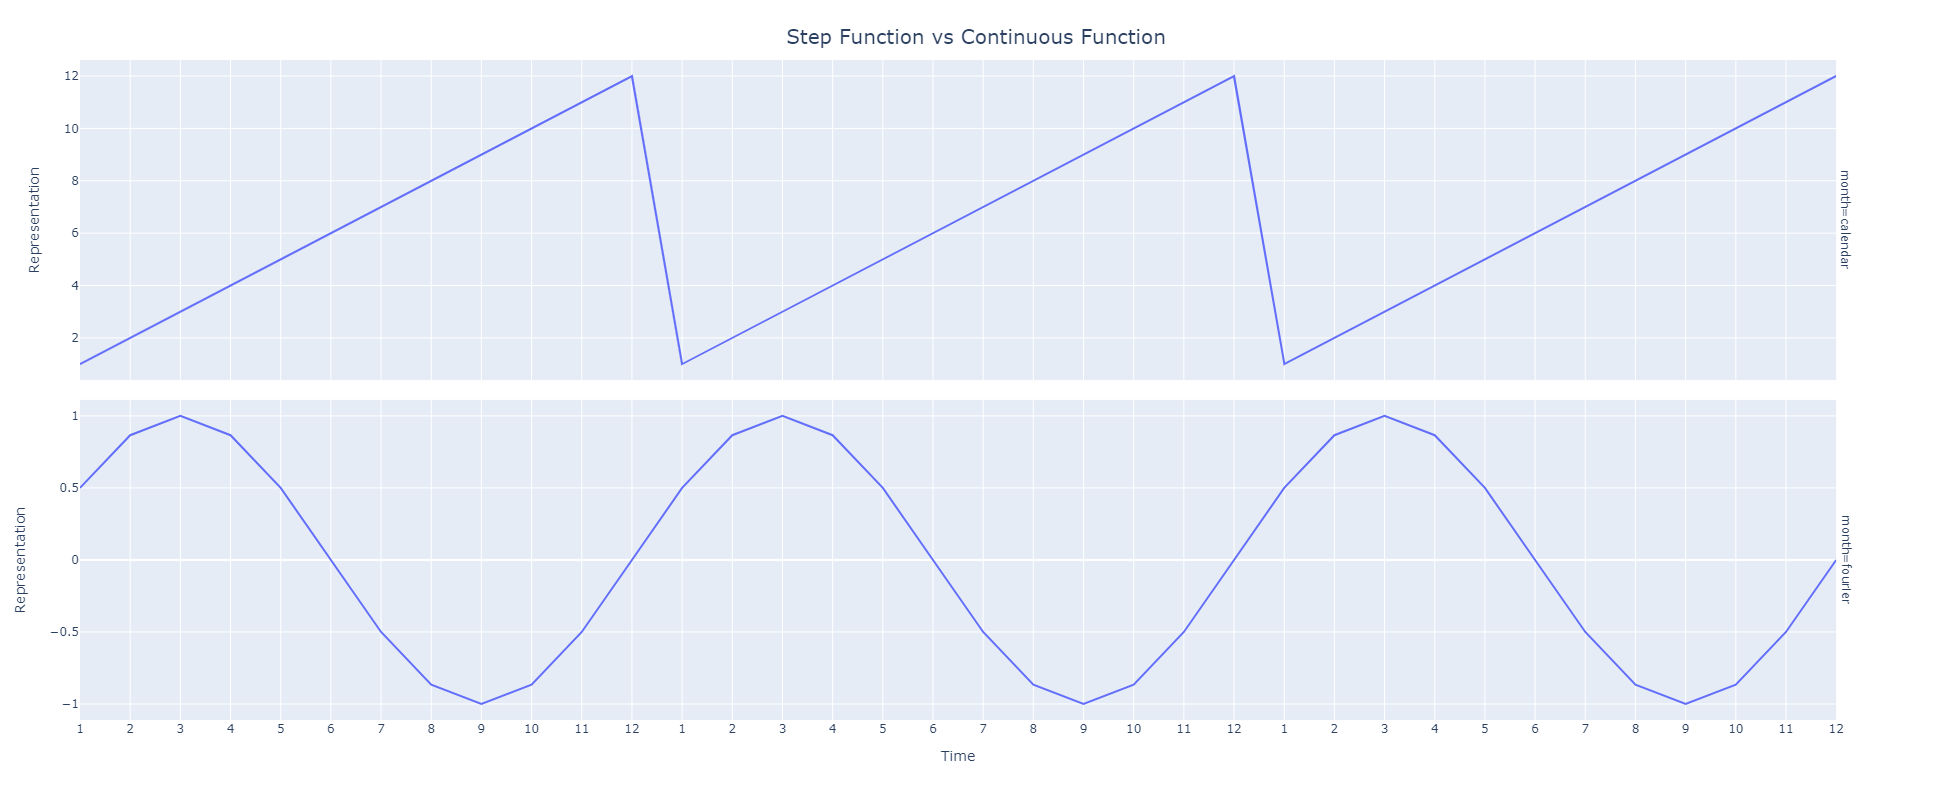

In [22]:
fig = px.line(plot_df, x="index", y="Representation", facet_row="month")
fig.update_layout(
            autosize=False,
            width=900,
            height=800,
            title_text="Step Function vs Continuous Function",
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            # yaxis=dict(
            #     # title_text=ylabel,
            #     # titlefont=dict(size=12),
            # ),
            xaxis=dict(
                title_text="Time",
                # titlefont=dict(size=12),
            )
        )
fig.update_yaxes(matches=None)
fig.update_xaxes(
    ticktext=np.arange(1,13).tolist()*3,
    tickvals=np.arange(len(plot_df))+1,
)
fig.write_image(f"imgs/chapter_6/fourier.png")
fig.show()

# Saving the feature engineered file

In [23]:
full_df.info(memory_usage="deep", verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11821680 entries, 0 to 32639
Columns: 90 entries, timestamp to timestamp_Minute_cos_5
dtypes: category(10), datetime64[ns](1), float32(63), int32(15), object(1)
memory usage: 4.4 GB


In [24]:
full_df[full_df['type']=="train"].drop(columns="type").to_parquet(preprocessed/"block_0-7_train_missing_imputed_feature_engg.parquet")
full_df[full_df['type']=="val"].drop(columns="type").to_parquet(preprocessed/"block_0-7_val_missing_imputed_feature_engg.parquet")
full_df[full_df['type']=="test"].drop(columns="type").to_parquet(preprocessed/"block_0-7_test_missing_imputed_feature_engg.parquet")